Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END clf__C=0.24400607090817547, clf__l1_ratio=None, clf__penalty=l1, clf__random_state=42, clf__solver=saga; total time=   3.1s
[CV] END clf__C=0.004207053950287938, clf__l1_ratio=None, clf__penalty=l2, clf__random_state=42, clf__solver=sag; total time=   0.3s
[CV] END clf__C=0.24400607090817547, clf__l1_ratio=None, clf__penalty=l1, clf__random_state=42, clf__solver=saga; total time=   3.6s
[CV] END clf__C=0.24400607090817547, clf__l1_ratio=None, clf__penalty=l1, clf__random_state=42, clf__solver=saga; total time=   3.6s
[CV] END clf__C=0.004207053950287938, clf__l1_ratio=None, clf__penalty=l2, clf__random_state=42, clf__solver=sag; total time=   0.4s
[CV] END clf__C=0.004207053950287938, clf__l1_ratio=None, clf__penalty=l2, clf__random_state=42, clf__solver=sag; total time=   0.3s
[CV] END clf__C=0.004207053950287938, clf__l1_ratio=None, clf__penalty=l2, clf__random_state=42, clf__solver=sag; total time=   0.3s
[CV] EN

/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

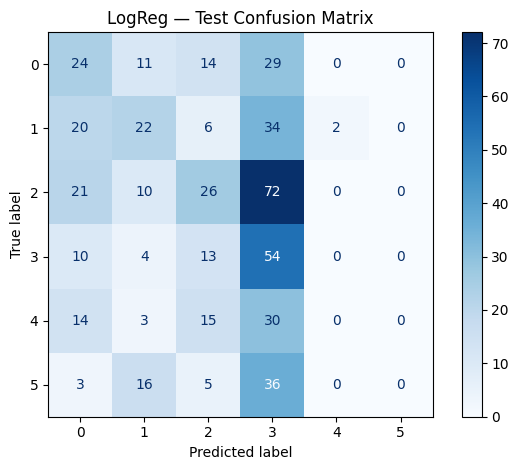

Test Set AUC (OvR): 0.6266

== Confidence Decile Table ==
      Top %  N Samples  Correct Predictions  Accuracy in Decile  \
0   Top 10%         49                   19               0.388   
1   Top 20%         98                   34               0.347   
2   Top 30%        148                   48               0.324   
3   Top 40%        197                   60               0.305   
4   Top 50%        247                   69               0.279   
5   Top 60%        296                   84               0.284   
6   Top 70%        345                   98               0.284   
7   Top 80%        395                  110               0.278   
8   Top 90%        444                  120               0.270   
9  Top 100%        494                  126               0.255   

   Avg Confidence  
0           0.474  
1           0.427  
2           0.399  
3           0.379  
4           0.363  
5           0.349  
6           0.337  
7           0.326  
8           0.316  
9   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from scipy.stats import loguniform, uniform

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
train_df = pd.read_csv("../data/generated_data/train.csv")
test_df = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df['regime_today'] = train_df['regime']
test_df['regime_today'] = test_df['regime']

train_df['regime_t+3'] = train_df['regime'].shift(-3)
test_df['regime_t+3'] = test_df['regime'].shift(-3)

train_df = train_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])
test_df = test_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])

# -----------------------------
# 2. Feature / Target Split
# -----------------------------
X_train = train_df.drop(columns=['regime_t+3'])
y_train = train_df['regime_t+3'].astype(int) - 1

X_test = test_df.drop(columns=['regime_t+3'])
y_test = test_df['regime_t+3'].astype(int) - 1

# -----------------------------
# 3. Scale Features
# -----------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Logistic Regression Optimization
# -----------------------------
pipeline_logreg = Pipeline([
    ('clf', LogisticRegression( max_iter=10000))
])

# Conditional search space
param_distributions_logreg = [
    {   # L1 penalty (only saga supports multinomial)
        'clf__penalty': ['l1'],
        'clf__solver': ['saga'],
        'clf__C': loguniform(0.001, 10),
        'clf__l1_ratio': [None],
        'clf__random_state': [42]
    },
    {   # L2 penalty
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'clf__C': loguniform(0.001, 10),
        'clf__l1_ratio': [None],
        'clf__random_state': [42]
    },
    {   # Elastic Net
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': loguniform(0.001, 10),
        'clf__l1_ratio': uniform(0, 1),
        'clf__random_state': [42]
    }
]



search_logreg = RandomizedSearchCV(
    estimator=pipeline_logreg,
    param_distributions=param_distributions_logreg,
    n_iter=50,
    scoring='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search_logreg.fit(X_train_scaled, y_train)

print("\n== Best Logistic Regression Params ==")
print(search_logreg.best_params_)
print(f"Best CV AUC (OvR): {search_logreg.best_score_:.4f}")

best_logreg = search_logreg.best_estimator_

# -----------------------------
# 5. Evaluate on Test Set
# -----------------------------
y_pred_test = best_logreg.predict(X_test_scaled)
y_test_proba = best_logreg.predict_proba(X_test_scaled)

print("\n== Logistic Regression — TEST Accuracy Report ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap="Blues", values_format="d")
plt.title("LogReg — Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Calculate Test AUC
auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print(f"Test Set AUC (OvR): {auc_score:.4f}")

# -----------------------------
# 6. Confidence-Based Decile Analysis
# -----------------------------
confidences = y_test_proba.max(axis=1)
y_pred = np.argmax(y_test_proba, axis=1)

# Build eval DataFrame
eval_df = pd.DataFrame({
    "true": y_test + 1,  # Reverse 0-indexing for readability
    "pred": y_pred + 1,
    "conf": confidences
})

eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
total_correct = eval_df["correct"].sum()

for d in range(10, 110, 10):  # Deciles: 10% to 100%
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    n_samples = len(subset)
    n_correct = subset["correct"].sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    avg_conf = subset["conf"].mean() if n_samples > 0 else 0

    decile_results.append({
        "Top %": f"Top {d}%",
        "N Samples": n_samples,
        "Correct Predictions": n_correct,
        "Accuracy in Decile": round(accuracy, 3),
        "Avg Confidence": round(avg_conf, 3)
    })

decile_df = pd.DataFrame(decile_results)
print("\n== Confidence Decile Table ==")
print(decile_df)
